In [ ]:
%%capture
!pip -q install rasterio matplotlib numpy

In [ ]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Calculate NDVI from the obtained images

First, you need to download the images from Google Earth Engine. [Here](https://colab.research.google.com/drive/1Ufv19gYDsOtnzE_SChdzhBrkiXZVq93g?usp=sharing) is my notebook for downloading Sentinel 2 images for the same aoi as drone image from GEE, based on Rasha's GEE workshop.

In [ ]:
# enter your google drive path where images are located
bf = rio.open('drive/My Drive/My_work/S2_drone_aoi_2020-05-13_before.tif')
af = rio.open('drive/My Drive/My_work/S2_drone_aoi_2020-06-02_after.tif')

In [ ]:
bf.descriptions # Red, Green, Blue, NIR

('B4', 'B3', 'B2', 'B8')

In [ ]:
af.descriptions # Red, Green, Blue, NIR

('B4', 'B3', 'B2', 'B8')

In [ ]:
# note that band indeces start from 1, not from 0
bf_red = bf.read(1)
bf_green = bf.read(2)
bf_blue = bf.read(3)
bf_nir = bf.read(4)

af_red = af.read(1)
af_green = af.read(2)
af_blue = af.read(3)
af_nir = af.read(4)

In [ ]:
bf_nir.max(), bf_nir.min(), af_nir.max(), af_nir.min()

(4900, 1031, 4040, 1339)

In [ ]:
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
bf_ndvi = (bf_nir.astype(float) - bf_red.astype(float)) / (bf_red.astype(float) + bf_nir.astype(float))
af_ndvi = (af_nir.astype(float) - af_red.astype(float)) / (af_red.astype(float) + af_nir.astype(float))

In [ ]:
bf_ndvi.min(), bf_ndvi.max()

(-0.04669440591770689, 0.8334902994914296)

In [ ]:
af_ndvi.min(), af_ndvi.max()

(0.0843000773395205, 0.7252080053968968)

## Calculate and visualize the NDVI difference

In [ ]:
diff_ndvi = bf_ndvi - af_ndvi

In [ ]:
diff_ndvi.min(), diff_ndvi.max()

(-0.278982941770004, 0.34101322961146147)

Visualize the difference

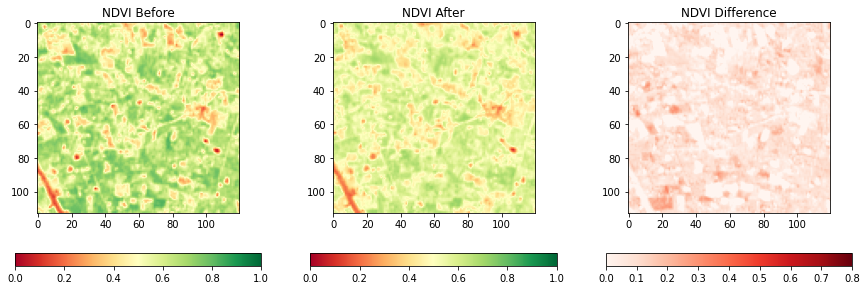

In [ ]:
colormap = plt.cm.RdYlGn
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(bf_ndvi, cmap=colormap)
imgplot.set_clim(0.0, 1.0)
ax.set_title('NDVI Before')
plt.colorbar(orientation='horizontal')

ax = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(af_ndvi, cmap=colormap)
imgplot.set_clim(0.0, 1.0)
ax.set_title('NDVI After')
plt.colorbar(orientation='horizontal')

ax = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(diff_ndvi, cmap=plt.cm.Reds)
imgplot.set_clim(0.0, 0.8) # 0.8 because the vegetation starts at NDVI = 0.2 -> max. damage is 0.8
ax.set_title('NDVI Difference')
plt.colorbar(orientation='horizontal')

Create a damage visualization mask with ranging transparency

In [ ]:
mask = diff_ndvi/0.8

In [ ]:
# Convert the mask to an image with 3 bands
mask = np.dstack((mask, mask, mask))

# normalize (range 0-1)
mask = (mask - mask.min()) / (mask.max() - mask.min())

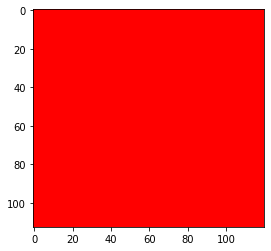

In [ ]:
# Create a red picture to superimpose
rows, cols = diff_ndvi.shape
red = np.zeros((rows, cols, 3))
red[:,:] = [1, 0, 0]  # Red block
red = (red * 255).astype(int)
plt.imshow(red)

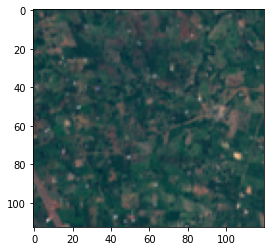

In [ ]:
# Construct RGB image (before the attack)
rgb = np.stack((bf_red, bf_green, bf_blue))
rgb = np.moveaxis(rgb, 0, -1)

# normalize and convert to range 0-255
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255
rgb = rgb.astype(int)
plt.imshow(rgb)

In [ ]:
masked_img = (red * mask + rgb * (1 - mask)).astype(int)

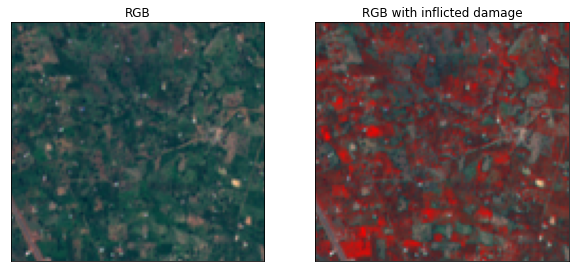

In [ ]:
fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('RGB')
ax.set_xticks([]); ax.set_yticks([])
img = plt.imshow(rgb)

ax = fig.add_subplot(1, 2, 2)
ax.set_title('RGB with inflicted damage')
ax.set_xticks([]); ax.set_yticks([])
img = plt.imshow(masked_img)